In [67]:
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


In [3]:
# Define paths
base_dir = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/'
metadata_dir = '/kaggle/input/lfw-dataset'
output_dir = "/kaggle/working/"
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Ensure the output directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Load metadata for splits
train_metadata = pd.read_csv(os.path.join(metadata_dir, 'peopleDevTrain.csv'))
test_metadata = pd.read_csv(os.path.join(metadata_dir, 'peopleDevTest.csv'))

# Function to normalize person names
def normalize_name(name):
    return '_'.join(name.replace('_', ' ').split()).strip()

# Function to copy images into training and testing folders
def prepare_dataset(df, img_folder, dest_folder):
    for index, row in df.iterrows():
        person_name = normalize_name(row['name'])
        images_count = int(row['images'])
        person_dir = os.path.join(dest_folder, person_name)  # Folder for the person
        os.makedirs(person_dir, exist_ok=True)

        # Format the image filename
        for i in range(1, images_count + 1):
            filename = f"{person_name}_{i:04d}.jpg"
            source_path = os.path.join(img_folder, person_name, filename)
            dest_path = os.path.join(person_dir, filename)

            # Check if the source file exists and copy
            if os.path.exists(source_path):
                shutil.copy(source_path, dest_path)

# Copy training images
prepare_dataset(train_metadata, base_dir, train_dir)
# Copy testing images
prepare_dataset(test_metadata, base_dir, test_dir)


In [4]:
# Function to count files in directories
def count_files(directory):
    """Count files in directories."""
    return sum(len(files) for _, _, files in os.walk(directory))

# Print counts to verify
print(f"Total training images: {count_files(train_dir)}")
print(f"Total testing images: {count_files(test_dir)}")

Total training images: 9525
Total testing images: 3708


In [418]:
# Function to create pairs and labels from matched and mismatched CSV files
def create_pairs_from_csv(match_csv, mismatch_csv, img_folder):
    """Create pairs and labels from CSV files."""
    pairs = []
    labels = []
    
    match_df = pd.read_csv(match_csv)
    mismatch_df = pd.read_csv(mismatch_csv)
    
    # Create positive pairs
    for _, row in match_df.iterrows():
        person_name = normalize_name(row['name'])
        img1 = f"{person_name}_{int(row['imagenum1']):04d}.jpg"
        img2 = f"{person_name}_{int(row['imagenum2']):04d}.jpg"
        pairs.append([os.path.join(img_folder, person_name, img1), os.path.join(img_folder, person_name, img2)])
        labels.append(1)
    
    # Create negative pairs
    for _, row in mismatch_df.iterrows():
        person1_name = normalize_name(row['name'])
        img1 = f"{person1_name}_{int(row['imagenum1']):04d}.jpg"
        person2_name = normalize_name(row['name.1'])
        img2 = f"{person2_name}_{int(row['imagenum2']):04d}.jpg"
        pairs.append([os.path.join(img_folder, person1_name, img1), os.path.join(img_folder, person2_name, img2)])
        labels.append(0)
    
    return np.array(pairs), np.array(labels)

# Load pairs from CSV files
train_match_csv = os.path.join(metadata_dir, 'matchpairsDevTrain.csv')
train_mismatch_csv = os.path.join(metadata_dir, 'mismatchpairsDevTrain.csv')
test_match_csv = os.path.join(metadata_dir, 'matchpairsDevTest.csv')
test_mismatch_csv = os.path.join(metadata_dir, 'mismatchpairsDevTest.csv')

train_pairs, train_labels = create_pairs_from_csv(train_match_csv, train_mismatch_csv, train_dir)
test_pairs, test_labels = create_pairs_from_csv(test_match_csv, test_mismatch_csv, test_dir)


In [419]:
# Check for class imbalance
print(f"Number of matched pairs in training set: {np.sum(train_labels == 1)}")
print(f"Number of mismatched pairs in training set: {np.sum(train_labels == 0)}")
print(f"Number of matched pairs in testing set: {np.sum(test_labels == 1)}")
print(f"Number of mismatched pairs in testing set: {np.sum(test_labels == 0)}")

Number of matched pairs in training set: 1100
Number of mismatched pairs in training set: 1100
Number of matched pairs in testing set: 500
Number of mismatched pairs in testing set: 500


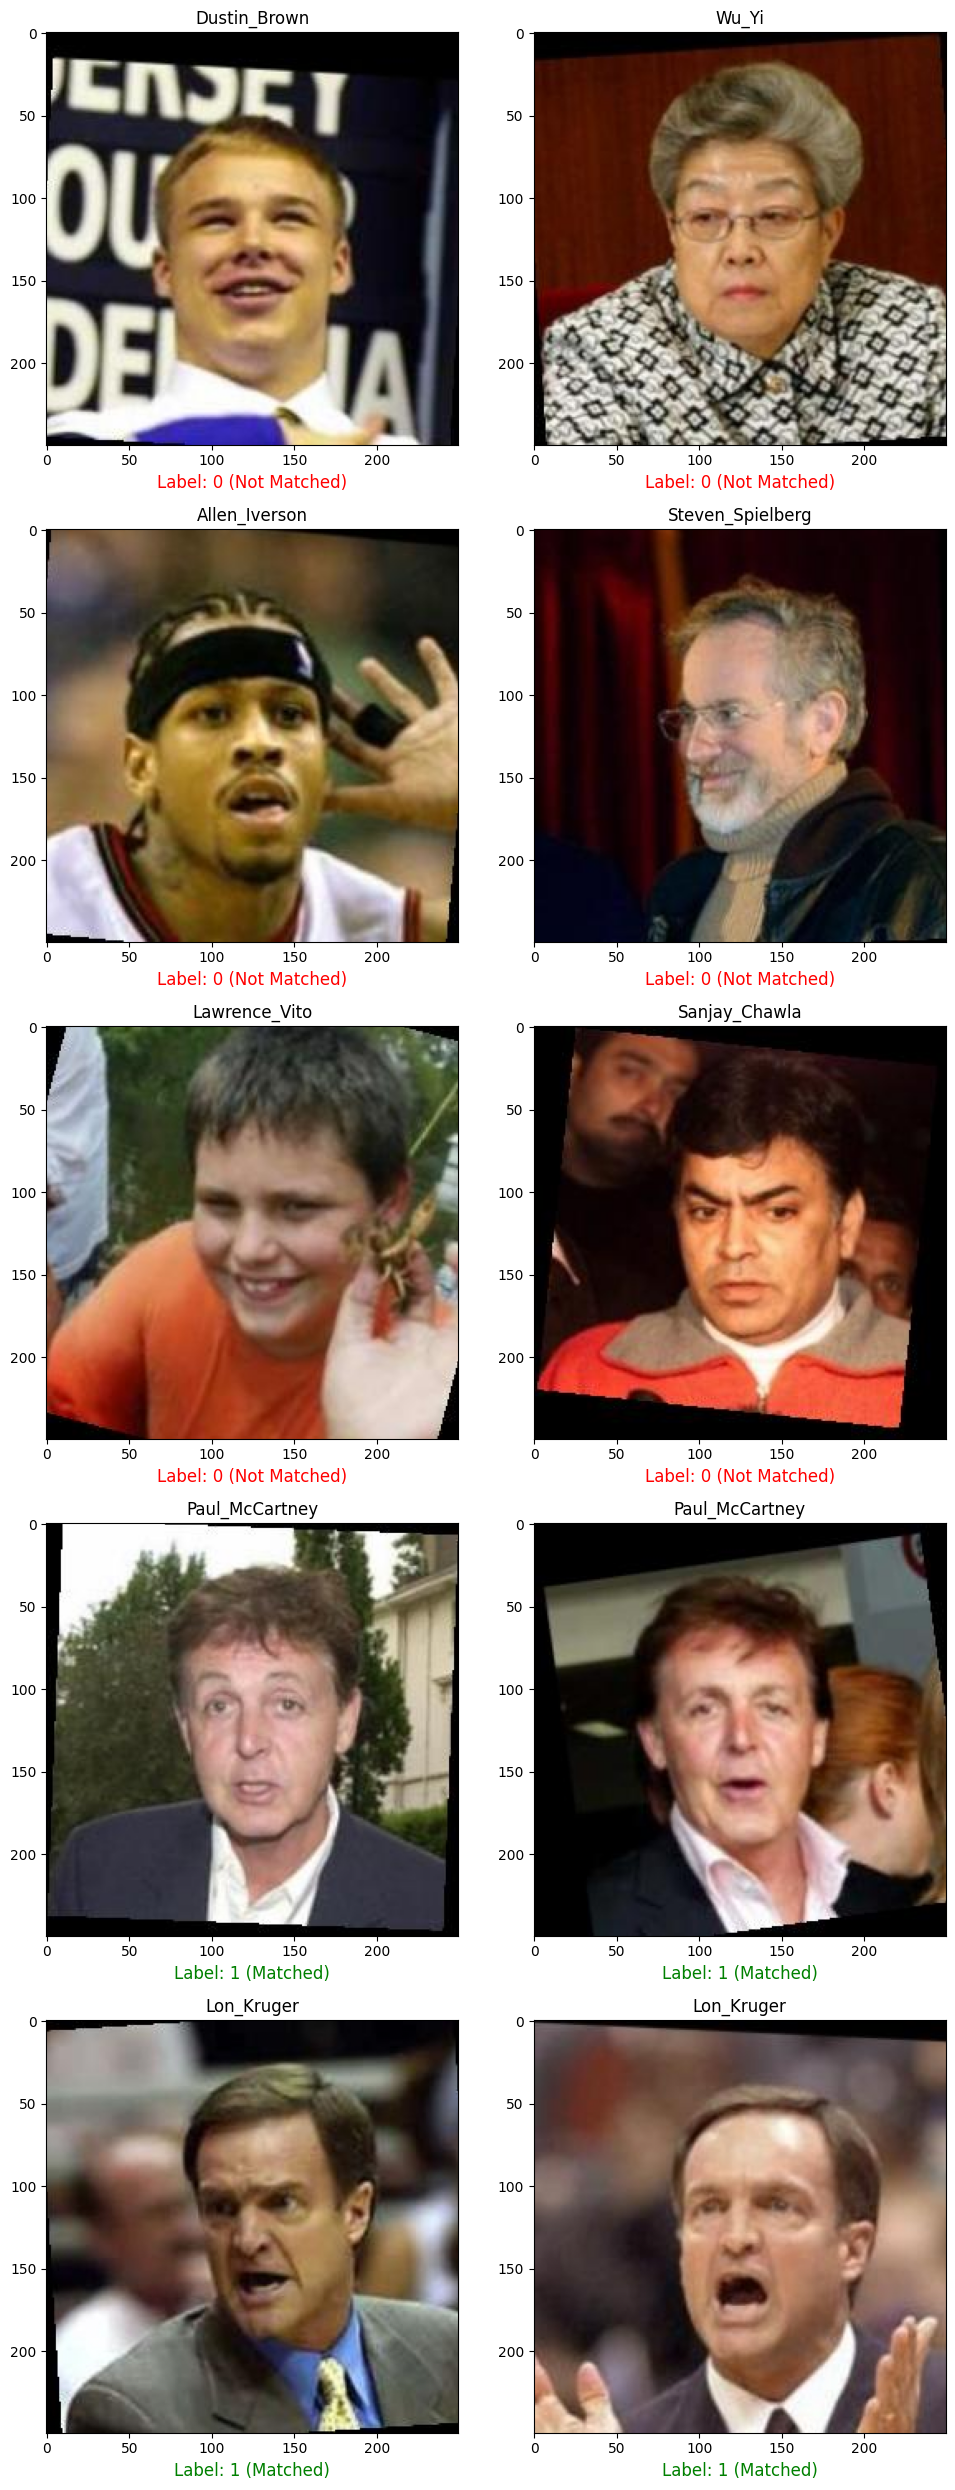

In [420]:
def visualize_random_pairs(pairs, labels, num_pairs=5):
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 5))
    
    for i in range(num_pairs):
        index = random.randint(0, len(pairs) - 1)
        pair = pairs[index]
        label = labels[index]
        
        # Extract person names from file paths
        person1_name = pair[0].split('/')[-2]
        person2_name = pair[1].split('/')[-2]

        # Load and plot first image
        img1 = plt.imread(pair[0])
        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(person1_name)

        # Load and plot second image
        img2 = plt.imread(pair[1])
        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(person2_name)

        # Set label
        if label == 1:
            label_text = 'Matched'
            color = 'green'
        else:
            label_text = 'Not Matched'
            color = 'red'

        # Print label
        axes[i, 0].set_xlabel(f'Label: {label} ({label_text})', color=color, fontsize=12)
        axes[i, 1].set_xlabel(f'Label: {label} ({label_text})', color=color, fontsize=12)

    plt.tight_layout()
    plt.show()

        
    
# Visualize random pairs
visualize_random_pairs(train_pairs, train_labels)


## Train Siamese Model with VGG16 base

In [421]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dot
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split


In [422]:
def preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image.astype(np.float32) / 255.0  # Normalize pixel values
    return image

def load_and_preprocess_pairs(pairs):
    processed_pairs = []
    for pair in pairs:
        img1_path, img2_path = pair
        img1 = preprocess_image(img1_path)
        img2 = preprocess_image(img2_path)
        processed_pairs.append([img1, img2])
    return np.array(processed_pairs)

train_pairs_processed = load_and_preprocess_pairs(train_pairs)
test_pairs_processed = load_and_preprocess_pairs(test_pairs)

In [423]:
# split the dataset into train and validation 
X_train, X_val, y_train, y_val = train_test_split(train_pairs_processed, train_labels, test_size=0.2, random_state=42)

In [424]:
X_train.shape

(1760, 2, 128, 128, 3)

In [425]:
INPUT_SHAPE = (128, 128, 3)
EPOCHS = 20
BATCH_SIZE =  32

# Define VGG16 base model (freeze layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Unfreeze last two layers for fine-tuning
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Define the Siamese network
input_1 = Input(shape=INPUT_SHAPE)
input_2 = Input(shape=INPUT_SHAPE)

# Use the same base model for both inputs
processed_1 = base_model(input_1)
processed_2 = base_model(input_2)

# Flatten the output
flatten_1 = Flatten()(processed_1)
flatten_2 = Flatten()(processed_2)

# Calculate cosine similarity between the two flattened embeddings
cosine_similarity = Dot(axes=1, normalize=True)([flatten_1, flatten_2])

# Additional layers for classification
x = Dense(512, activation='relu')(cosine_similarity)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer for binary classification (matched or mismatched)
output = Dense(1, activation='sigmoid')(x)

# Create the Siamese model
siamese_model = Model(inputs=[input_1, input_2], outputs=output)

# Compile the model
siamese_model.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['accuracy'])

siamese_model.summary()

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_85      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_86      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 4, 4, 512) │ 14,714,688 │ input_layer_85[0… │
│                     │                   │            │ input_layer_86[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_57          │ (None, 8192)      │          0 │ vgg16[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_58          │ (None, 8192)      │          0 │ vgg16[1][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_16 (Dot)        │ (None, 1)         │          0 │ flatten_57[0][0], │
│                     │                   │            │ flatten_58[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 512)       │      1,024 │ dot_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 512)       │          0 │ dense_72[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 256)       │    131,328 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 256)       │          0 │ dense_73[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 1)         │        257 │ dropout_49[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,847,297 (56.64 MB)

 Trainable params: 2,492,417 (9.51 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [426]:
# Define paths
checkpoint_path = "/kaggle/working/siamese_model.keras"
# Define model callbacks
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model using
history= siamese_model.fit(
  [X_train[:, 0], X_train[:, 1]], y_train,
  validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.5146 - loss: 0.6954 - val_accuracy: 0.6045 - val_loss: 0.6910
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5354 - loss: 0.6897 - val_accuracy: 0.6750 - val_loss: 0.6554
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7039 - loss: 0.6353 - val_accuracy: 0.7114 - val_loss: 0.5787
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8041 - loss: 0.4821 - val_accuracy: 0.7682 - val_loss: 0.5027
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8826 - loss: 0.3153 - val_accuracy: 0.7455 - val_loss: 0.5363
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9437 - loss: 0.1981 - val_accuracy: 0.7386 - val_loss: 0.6303
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9726 - loss: 0.1177 - val_accuracy: 0.7432 - val_loss: 0.6829
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9749 - loss: 0.0886 - val_accuracy: 0.7295 - 

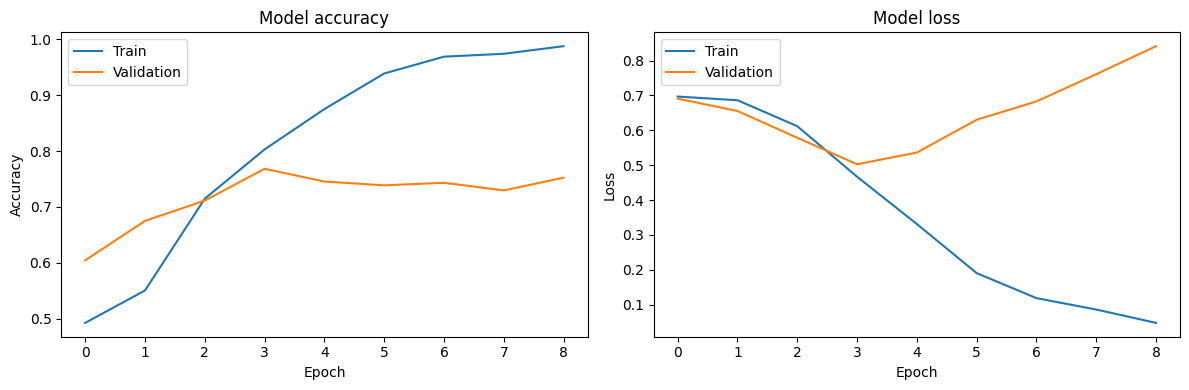

In [427]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## Evaluate the Model 

In [428]:
# Evaluate on test data
test_loss, test_accuracy = siamese_model.evaluate(
  [test_pairs_processed[:, 0], test_pairs_processed[:, 1]], test_labels,
  batch_size=16
)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8028 - loss: 0.6422
Test Loss: 1.1124
Test Accuracy: 0.7150


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


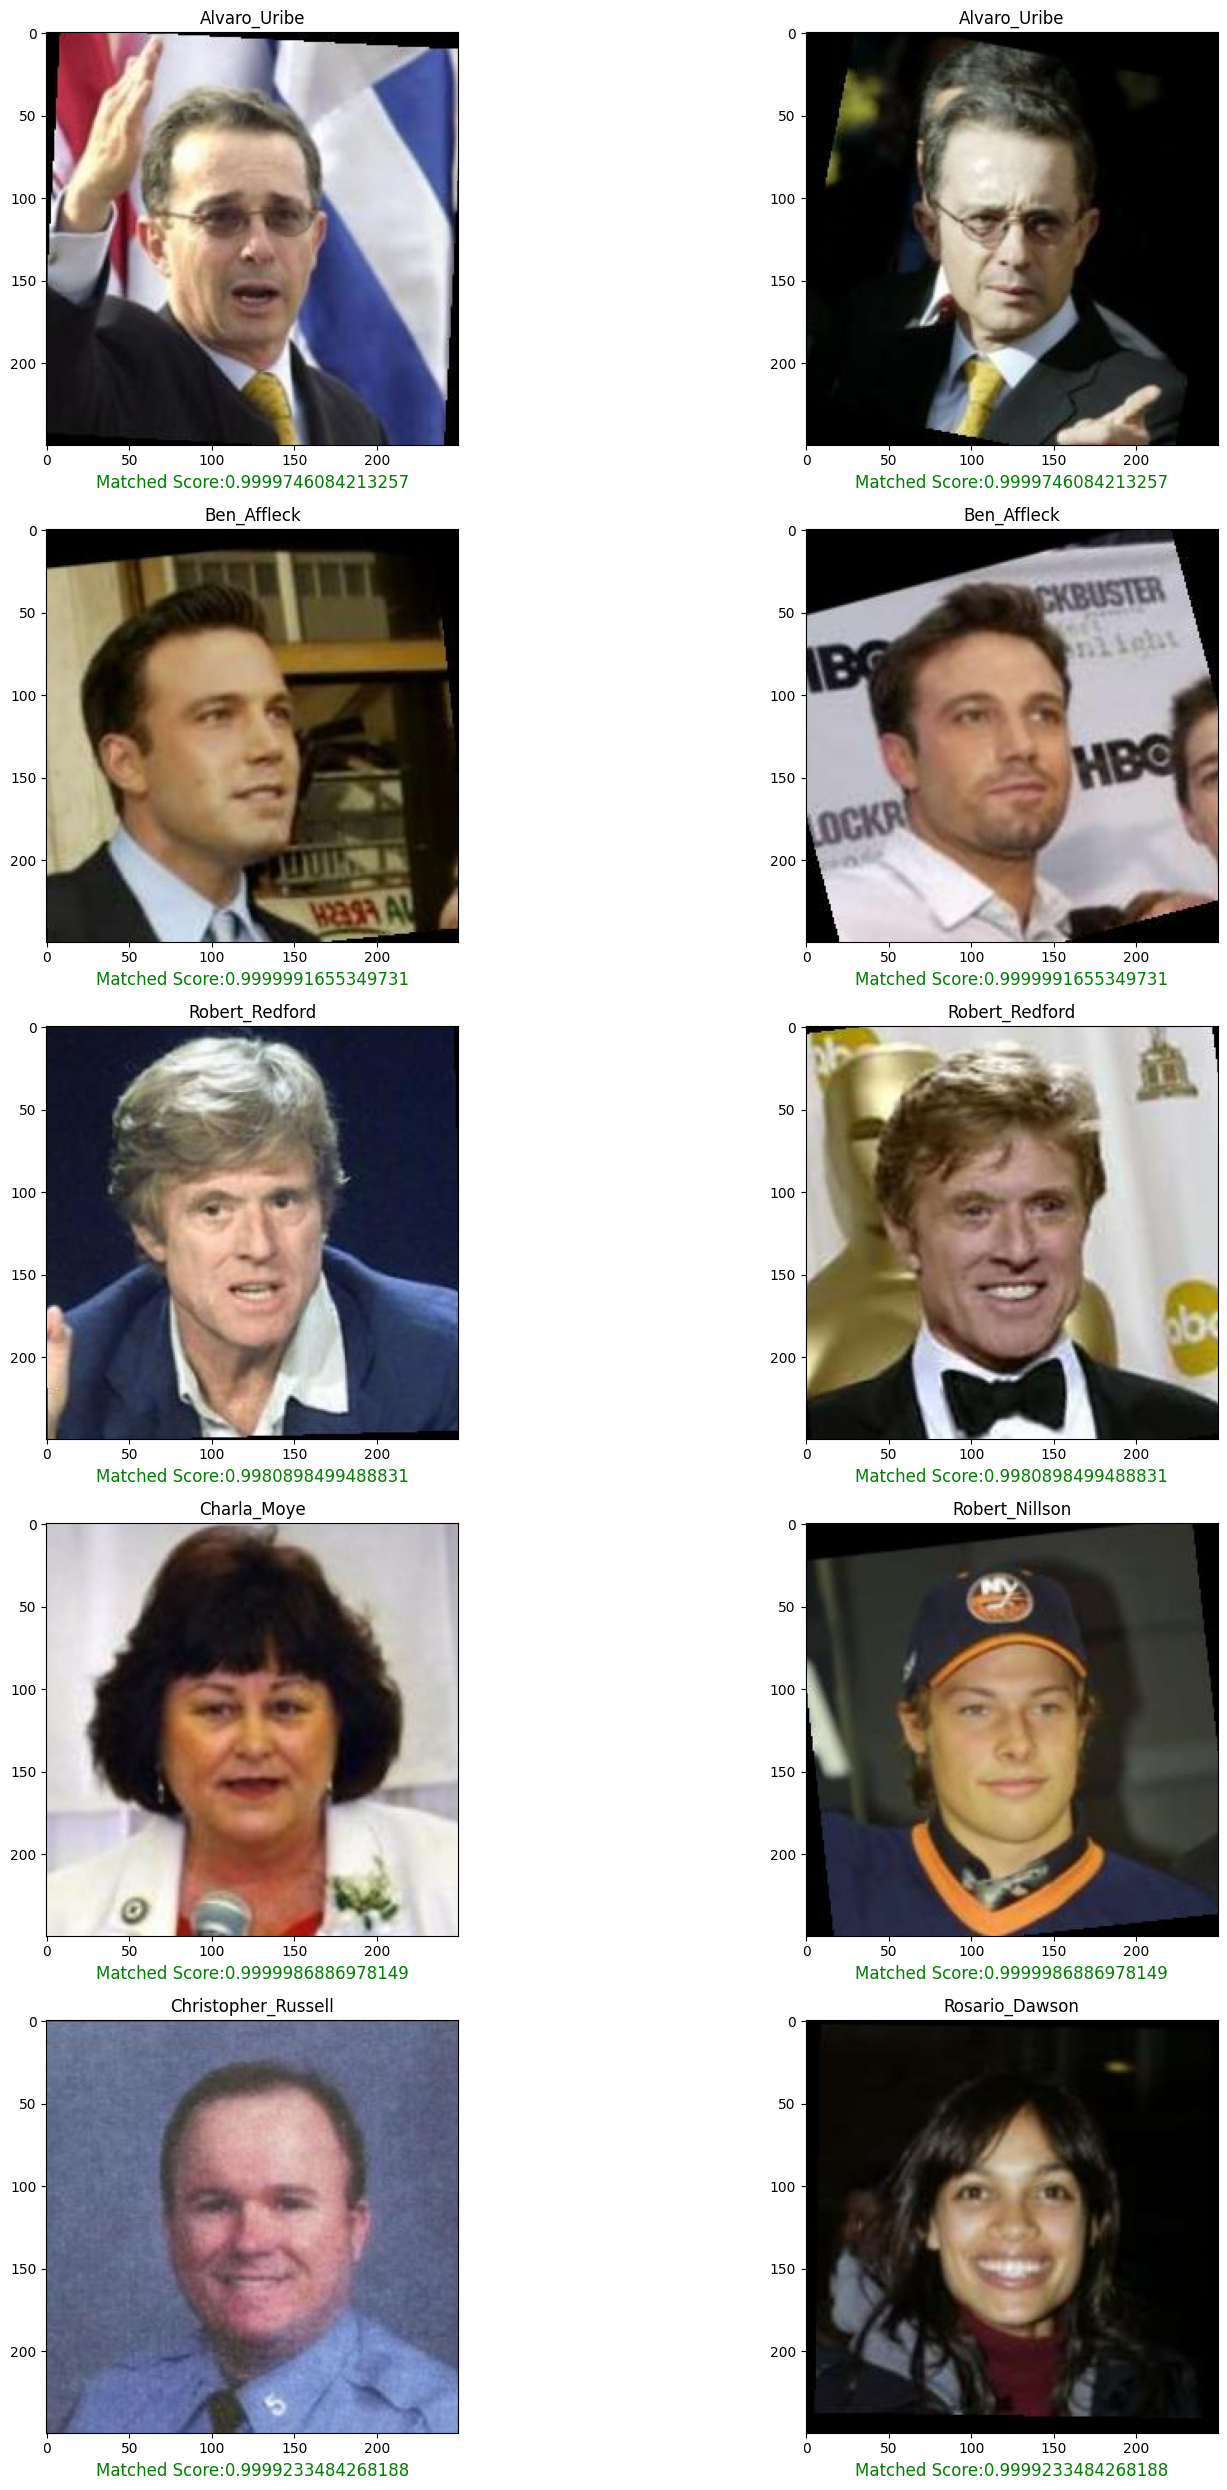

In [434]:
def visualize_test_pairs_with_predictions(model, test_pairs, test_labels, num_pairs=5):
    fig, axes = plt.subplots(num_pairs, 2, figsize=(18, num_pairs * 5))
    
    for i in range(num_pairs):
        index = random.randint(0, len(test_pairs) - 1)
        pair = test_pairs[index]
        label = test_labels[index]

        # Load and preprocess images
        img1_path, img2_path = pair[0], pair[1]
        img1 = preprocess_image(img1_path)
        img2 = preprocess_image(img2_path)

        # Expand dimensions to match model input shape
        img1 = np.expand_dims(img1, axis=0)
        img2 = np.expand_dims(img2, axis=0)

        # Predict score
        score = model.predict([img1, img2])[0][0]
        if score >= 0.7:
            prediction_text = f'Matched Score:{score}'
            color = 'green'
        else:
            prediction_text = f'Not Matched Score:{score}'
            color = 'red'

        # Plot first image
        axes[i, 0].imshow(Image.open(img1_path))
        person1_name = img1_path.split('/')[-2]
        axes[i, 0].set_title(person1_name)

        # Plot second image
        axes[i, 1].imshow(Image.open(img2_path))
        person2_name = img2_path.split('/')[-2] 
        axes[i, 1].set_title(person2_name)

        # Print prediction as title
        axes[i, 0].set_xlabel(prediction_text, color=color, fontsize=12)
        axes[i, 1].set_xlabel(prediction_text, color=color, fontsize=12)

    plt.tight_layout()
    plt.show()

# Visualize random test pairs with predictions
visualize_test_pairs_with_predictions(siamese_model, test_pairs, test_labels)


In [436]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_loss, test_accuracy = siamese_model.evaluate([test_pairs_processed[:, 0], test_pairs_processed[:, 1]], test_labels)

# Predict probabilities
y_pred_probs = siamese_model.predict([test_pairs_processed[:, 0], test_pairs_processed[:, 1]])

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate metrics
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8009 - loss: 0.6563
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Test Loss: 1.1124019622802734
Test Accuracy: 0.7149999737739563
Precision: 0.6692913385826772
Recall: 0.85
F1-score: 0.7488986784140969


## Convert Model to ONNX

In [383]:
%%capture
pip install tf2onnx # to convert from tensorflow to onnx format

In [440]:
siamese_model.save("/kaggle/working/siamese_model.h5")

In [441]:
import tf2onnx

# Load the saved Keras model
keras_model = tf.keras.models.load_model('/kaggle/working/siamese_model.h5')

# Convert the Keras model to ONNX
onnx_model_path = '/kaggle/working/siamese_model.onnx'
spec = (tf.TensorSpec((None, 128, 128, 3), tf.float32, name="input_1"), tf.TensorSpec((None, 128, 128, 3), tf.float32, name="input_2"))
model_proto, _ = tf2onnx.convert.from_keras(keras_model, input_signature=spec, opset=13)
with open(onnx_model_path, "wb") as f:
    f.write(model_proto.SerializeToString())